Testing Validation

In [2]:
# Required libraries
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import random
import time
from statistics import mean 
import pandas as pd

In [3]:
#generate graph
def graph_gen(V, density):
    # Generates a connected graph with V nodes and target density.
    G = nx.Graph()
    G.add_nodes_from(range(V))

    # Calculate the number of edges base on density
    edges_num = int(density * V * (V - 1) / 2)

    # Ensure minimum number of edges for connectivity
    edges_num = max(edges_num, V-1)

    # Generate edges randomly
    edges = set()
    while len(edges) < edges_num:
        u = random.randint(0, V - 1)
        v = random.randint(0, V - 1)
        if u != v and (u, v) not in edges and (v, u) not in edges:
            edges.add((u, v))

    # Add edges to the graph
    G.add_edges_from(edges)

    # Random the weight of edges
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 25)
    # Ensure connectivity
    if not nx.is_connected(G):
        return graph_gen(V, density)

    return G
        
def neg_graph_gen(V, density):
    #Generates a connected graph with V nodes and target density with negative weight.
    G = nx.Graph()
    G.add_nodes_from(range(V))

    # Calculate the number of edges base on density
    edges_num = int(density * V * (V - 1) / 2)

    # Ensure minimum number of edges for connectivity
    edges_num = max(edges_num, V-1)

    # Generate edges randomly
    edges = set()
    while len(edges) < edges_num:
        u = random.randint(0, V - 1)
        v = random.randint(0, V - 1)
        if u != v and (u, v) not in edges and (v, u) not in edges:
            edges.add((u, v))

    # Add edges to the graph
    G.add_edges_from(edges)

    # Random the weight of edges
    for (u, v) in G.edges():
        weight_check = random.randint(-25, 24)
        if weight_check >= 0:
            G.edges[u, v]['weight'] = weight_check + 1
        else:
            G.edges[u, v]['weight'] = weight_check

        
    # Ensure connectivity
    if not nx.is_connected(G):
        return neg_graph_gen(V, density)
    return G

#Prim algorithm with time calculation
def prim_mst(graph):
    """Finds the Minimum Spanning Tree of a weighted graph using Prim's algorithm."""
    
    start_time = time.perf_counter()
    
    # Graph for MST and total weight of it
    MST = nx.Graph()
    total_weight = 0
    # Start with an optional node, here 0
    start = list(graph.nodes())[0]
    # Set to store visited nodes
    visited = set()
    visited.add(start)
    # Priority queue to store edges with their weight
    edge_queue = []
    # Add all edges, neighbors of starting node to queue
    for neighbor, values in graph[start].items():
        heapq.heappush(edge_queue, (values['weight'], start, neighbor))
    
    # Go for edges with lowest weight first
    while edge_queue is not None and len(MST.nodes) < len(graph.nodes):
        weight, node, neighbor = heapq.heappop(edge_queue)

        if neighbor not in visited:
            visited.add(neighbor)
            MST.add_edge(node, neighbor, weight = weight)
            total_weight += weight

            # Add all edges, neighbors of new nodes to queue
            for neighbor_v, values in graph[neighbor].items():
                if neighbor_v not in visited:
                    heapq.heappush(edge_queue, (values['weight'], neighbor, neighbor_v))
    
    run_time = (time.perf_counter() - start_time) * 1000  # Convert to milliseconds
    
    return MST, total_weight, run_time

#Kruskal algorithm with time calculation
def kruskal_mst(graph):
    """Finds the Minimum Spanning Tree of a weighted graph using Kruskal's algorithm."""

    start_time = time.perf_counter()

    def look(parent, i):
        """Find the root of the set in which element i belongs."""
        if parent[i] == i:
            return i
        return look(parent, parent[i])

    def apply_union(parent, rank, x, y):
        """Perform the union of two sets."""
        xroot = look(parent, x)
        yroot = look(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    # Graph for MST and total weight of it
    MST = nx.Graph()
    total_weight = 0
    # Sort edges by their weight
    edge_list = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'])

    parent = []
    rank = []

    for node in range(len(graph.nodes())):
        parent.append(node)
        rank.append(0)
    
    # If we've already added enough edges to form the MST, break early
    while len(MST.nodes()) < len(graph.nodes()):
        # Process edges in order of their weight
        for u, v, values in edge_list:
            # Find roots of the sets to which u and v belong
            if look(parent, u) != look(parent, v):
                # If u and v are in different sets, add the edge to the MST
                MST.add_edge(u, v, weight=values['weight'])
                apply_union(parent, rank, u, v)
    weight_list = list(MST.edges.data("weight", default=1))
    for i in range(len(weight_list)):
        total_weight += weight_list[i][2]

    run_time = (time.perf_counter() - start_time) * 1000  # Convert to milliseconds

    return MST, total_weight, run_time

Testing on sparse graph

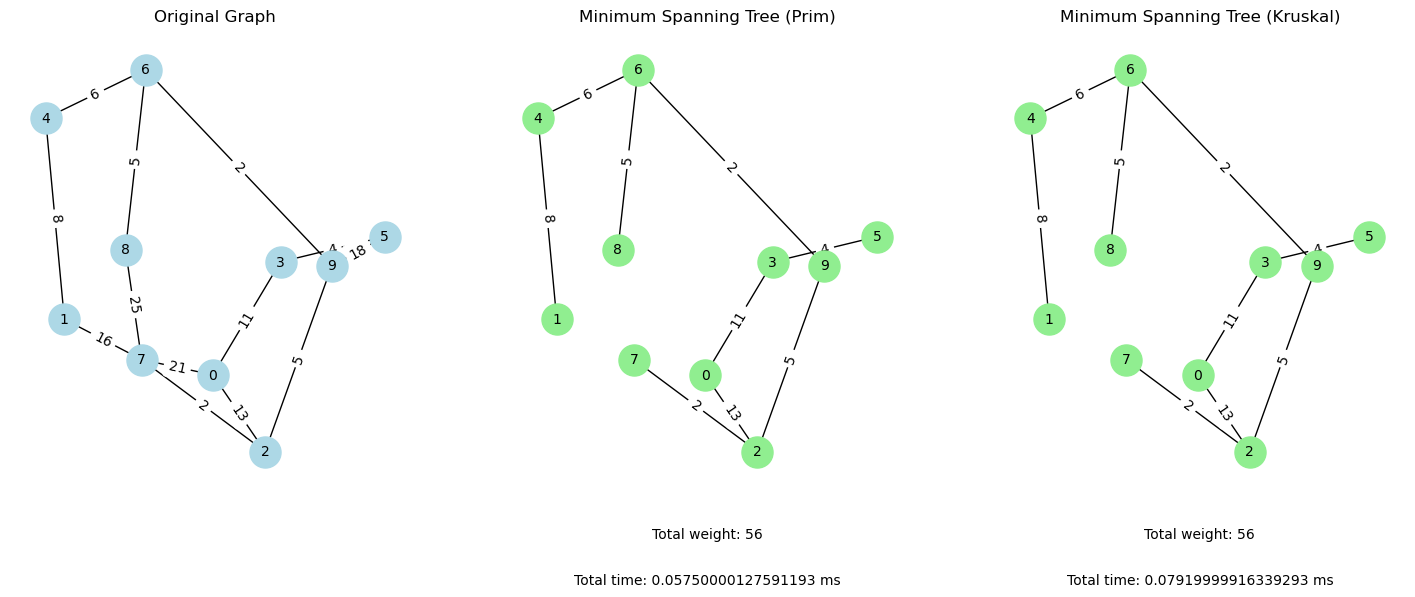

In [11]:
V = 10
density = 0.3
G = graph_gen(V, density)
mst_kruskal, total_weight_kruskal, time_kruskal = kruskal_mst(G)
mst_prim, total_weight_prim, time_prim = prim_mst(G)

def visualize_graphs(graph, mst_prim, mst_kruskal):
    """Visualizes the original graph and its MST with edge weights."""
    plt.figure(figsize=(18, 6))

    # Original graph
    plt.subplot(131)  # Change this from 133 to 131
    pos = nx.spring_layout(graph)  # Layout for visualization
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Original Graph")

    # MST_Prim
    plt.subplot(132)  # Change this from 131 to 132
    nx.draw(mst_prim, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_prim, 'weight')
    nx.draw_networkx_edge_labels(mst_prim, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Prim)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_prim}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_prim} ms", ha='center', transform=plt.gca().transAxes)

    # MST_Kruskal
    plt.subplot(133)  # Change this from 132 to 133
    nx.draw(mst_kruskal, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_kruskal, 'weight')
    nx.draw_networkx_edge_labels(mst_kruskal, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Kruskal)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_kruskal}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_kruskal} ms", ha='center', transform=plt.gca().transAxes)

    plt.show()

# Visualize graphs
visualize_graphs(G, mst_prim, mst_kruskal)

Testing on dense graph

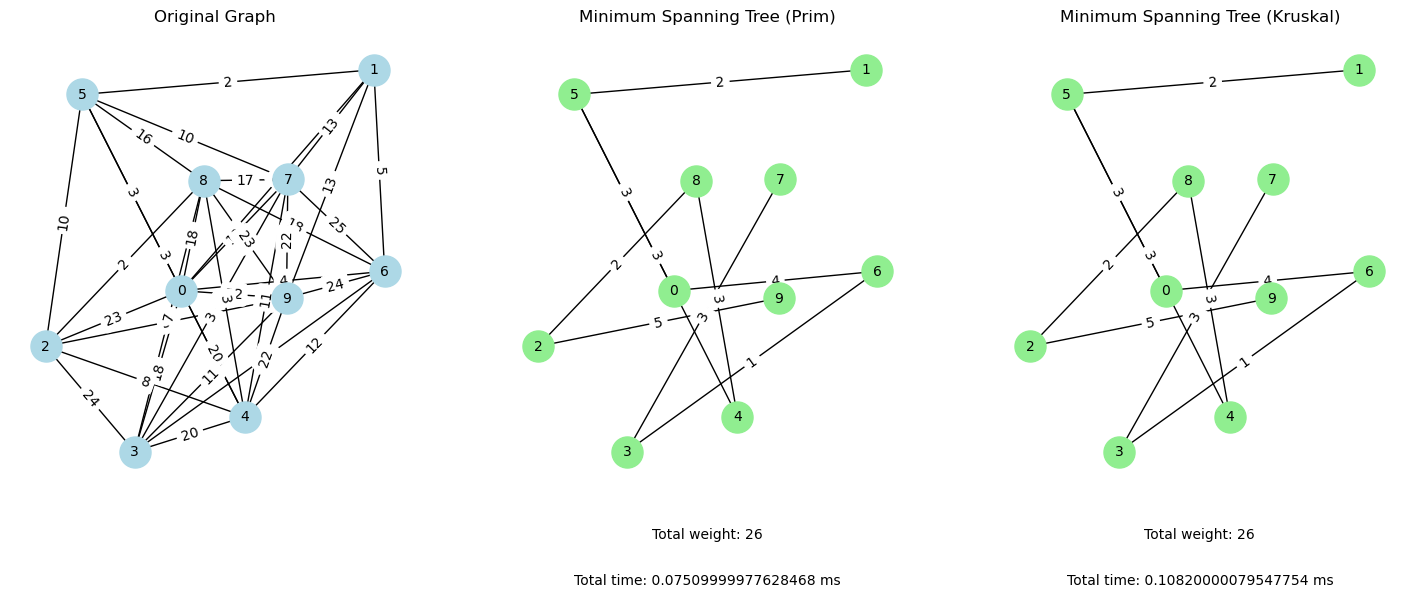

In [96]:
V = 10
density = 0.8
G = graph_gen(V, density)
mst_kruskal, total_weight_kruskal, time_kruskal = kruskal_mst(G)
mst_prim, total_weight_prim, time_prim = prim_mst(G)

def visualize_graphs(graph, mst_prim, mst_kruskal):
    """Visualizes the original graph and its MST with edge weights."""
    plt.figure(figsize=(18, 6))

    # Original graph
    plt.subplot(131)  # Change this from 133 to 131
    pos = nx.spring_layout(graph)  # Layout for visualization
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Original Graph")

    # MST_Prim
    plt.subplot(132)  # Change this from 131 to 132
    nx.draw(mst_prim, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_prim, 'weight')
    nx.draw_networkx_edge_labels(mst_prim, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Prim)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_prim}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_prim} ms", ha='center', transform=plt.gca().transAxes)

    # MST_Kruskal
    plt.subplot(133)  # Change this from 132 to 133
    nx.draw(mst_kruskal, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_kruskal, 'weight')
    nx.draw_networkx_edge_labels(mst_kruskal, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Kruskal)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_kruskal}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_kruskal} ms", ha='center', transform=plt.gca().transAxes)

    plt.show()

# Visualize graphs
visualize_graphs(G, mst_prim, mst_kruskal)

Testing on graph with negative weight

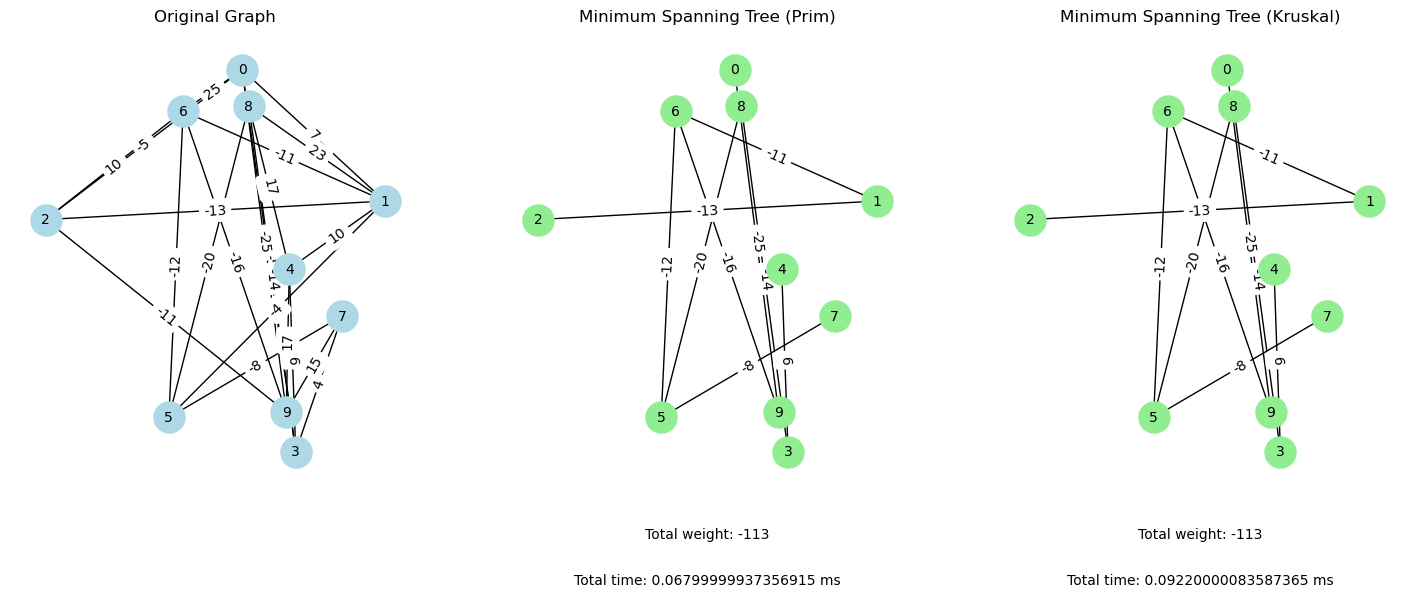

In [97]:
V = 10
density = 0.5
G = neg_graph_gen(V, density)
mst_kruskal, total_weight_kruskal, time_kruskal = kruskal_mst(G)
mst_prim, total_weight_prim, time_prim = prim_mst(G)

def visualize_graphs(graph, mst_prim, mst_kruskal):
    """Visualizes the original graph and its MST with edge weights."""
    plt.figure(figsize=(18, 6))

    # Original graph
    plt.subplot(131)  # Change this from 133 to 131
    pos = nx.spring_layout(graph)  # Layout for visualization
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Original Graph")

    # MST_Prim
    plt.subplot(132)  # Change this from 131 to 132
    nx.draw(mst_prim, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_prim, 'weight')
    nx.draw_networkx_edge_labels(mst_prim, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Prim)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_prim}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_prim} ms", ha='center', transform=plt.gca().transAxes)

    # MST_Kruskal
    plt.subplot(133)  # Change this from 132 to 133
    nx.draw(mst_kruskal, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10)
    mst_edge_labels = nx.get_edge_attributes(mst_kruskal, 'weight')
    nx.draw_networkx_edge_labels(mst_kruskal, pos, edge_labels=mst_edge_labels)
    plt.title("Minimum Spanning Tree (Kruskal)")
    plt.text(0.5, -0.1, f"Total weight: {total_weight_kruskal}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, f"Total time: {time_kruskal} ms", ha='center', transform=plt.gca().transAxes)

    plt.show()

# Visualize graphs
visualize_graphs(G, mst_prim, mst_kruskal)

Summary testing of total weight performance of Prim and Kruskal algorithm


In [130]:
# Test will be run on density range from 0.1 to 1 and number of vertices = 10
# Each density will be executed 1000 times
nodes_no = 10
density_range = [0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
avg_total_weight_prim = []
avg_total_weight_kruskal = []

for density in density_range:

    # temp list to store list of 1000 test on each density
    temp_prim = []
    temp_kruskal = []

    for i in range(1000):
        G = graph_gen(nodes_no, density)
        mst_kruskal, total_weight_kruskal, time_kruskal = kruskal_mst(G)
        mst_prim, total_weight_prim, time_prim = prim_mst(G)
        temp_prim.append(total_weight_prim)
        temp_kruskal.append(total_weight_kruskal)

    avg_total_weight_kruskal.append(mean(temp_kruskal))
    avg_total_weight_prim.append(mean(temp_prim))

percentage_difference = [
    ((kruskal - prim) / ((kruskal + prim) / 2)) * 100
    for kruskal, prim in zip(avg_total_weight_kruskal, avg_total_weight_prim)
]

df = pd.DataFrame({
    'Density': density_range,
    'Average Total Weight (Kruskal)': avg_total_weight_kruskal,
    'Average Total Weight (Prim)': avg_total_weight_prim,
    'Diffenrent(%)': percentage_difference
})

print(df.to_string(index=False))

 Density  Average Total Weight (Kruskal)  Average Total Weight (Prim)  Diffenrent(%)
     0.1                         118.385                      118.385            0.0
     0.2                         116.086                      116.086            0.0
     0.3                          91.722                       91.722            0.0
     0.4                          70.432                       70.432            0.0
     0.5                          60.216                       60.216            0.0
     0.6                          50.800                       50.800            0.0
     0.7                          44.813                       44.813            0.0
     0.8                          39.887                       39.887            0.0
     0.9                          36.148                       36.148            0.0
     1.0                          32.662                       32.662            0.0


Summary testing of total weight performance of Prim and Kruskal algorithm with negative weight

In [134]:
# Test will be run on density range from 0.1 to 1 and number of vertices = 10 and negative edges's weight
# Each density will be executed 1000 times
nodes_no = 10
density_range = [0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
avg_total_weight_prim = []
avg_total_weight_kruskal = []

for density in density_range:

    # temp list to store list of 1000 test on each density
    temp_prim = []
    temp_kruskal = []

    for i in range(1000):
        G = neg_graph_gen(nodes_no, density)
        mst_kruskal, total_weight_kruskal, time_kruskal = kruskal_mst(G)
        mst_prim, total_weight_prim, time_prim = prim_mst(G)
        temp_prim.append(total_weight_prim)
        temp_kruskal.append(total_weight_kruskal)

    avg_total_weight_kruskal.append(mean(temp_kruskal))
    avg_total_weight_prim.append(mean(temp_prim))

percentage_difference = [
    (abs((kruskal - prim) / ((kruskal + prim) / 2)) * 100)
    for kruskal, prim in zip(avg_total_weight_kruskal, avg_total_weight_prim)
]

df = pd.DataFrame({
    'Density': density_range,
    'Average Total Weight (Kruskal)': avg_total_weight_kruskal,
    'Average Total Weight (Prim)': avg_total_weight_prim,
    'Diffenrent(%)': percentage_difference
})

print(df.to_string(index=False))

 Density  Average Total Weight (Kruskal)  Average Total Weight (Prim)  Diffenrent(%)
     0.1                          -0.369                       -0.369            0.0
     0.2                          -0.567                       -0.567            0.0
     0.3                         -50.467                      -50.467            0.0
     0.4                         -92.762                      -92.762            0.0
     0.5                        -115.902                     -115.902            0.0
     0.6                        -136.914                     -136.914            0.0
     0.7                        -147.613                     -147.613            0.0
     0.8                        -160.425                     -160.425            0.0
     0.9                        -167.164                     -167.164            0.0
     1.0                        -174.033                     -174.033            0.0


Summary: Prim’s and Kruskal’s algorithms yield identical total weights, indicating no difference in their results.